# Task 4.4 Supervised Learning - Classification and hyperparameter tuning

- Load Dataset
    - Use the COX-2 Activity dataset (see also caret datasets). Try to understand the research question. 
- Split the Dataset
    - Use train_test_split() to create 75% training and 25% test sets.
- Select a Learning Method
    - Use RandomForestClassifier from sklearn.ensemble.
    - Apply preprocessing (scaling/centering) if necessary.
- (Optional) Define a Tuning Grid
    - Use GridSearchCV to tune hyperparameters (e.g., n_estimators, max_depth, mtry).
- Perform 10-Fold Cross-Validation
    - Use cross_val_score or define cv=10 inside GridSearchCV.
- Analyze Performance
    - Print model performance metrics and feature importances (model.feature_importances_).
- Apply the Final Model
    - Use predict() on the test data.
    - Evaluate performance using mean_squared_error, r2_score, or similar metrics.
    - IMPORTANT: If preprocessing was applied, apply the same transformation to the test set before prediction.

In [11]:
# Preparations

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

cox2_df = pd.read_csv('cox2.csv')
cox2_df.head()

print("Dataset summary:")
print(f"Number of samples: {cox2_df.shape[0]}")
print(f"Number of features: {cox2_df.shape[1] - 1}")

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(cox2_df['cox2Class'])


# Splitting the dataset using train_test_split

X = cox2_df.drop('cox2Class', axis=1) 
y = cox2_df['cox2Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"\n\nAufteilung in Training- und Test-Dataset:")
print(f"Training Dataset: {X_train.shape[0]} samples")
print(f"Test Dataset: {X_test.shape[0]} samples")

Dataset summary:
Number of samples: 462
Number of features: 256


Aufteilung in Training- und Test-Dataset:
Training Dataset: 346 samples
Test Dataset: 116 samples


In [5]:
# Fitting a learning method and defining a tuning grid (this part was solved with the help of claude.ai)

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('rf', RandomForestClassifier(random_state=42))  # Random Forest model
])

param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_features': ['sqrt', 'log2', None]
}

In [7]:
# Performing 10-fold cross-validation (this part was solved with the help of claude.ai)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,  # 10-fold cross-validation
    scoring='accuracy',  # Use appropriate metric for classification
    verbose=1,
    n_jobs=-1
)

# Fit the grid search model
print("\nPerforming grid search with 10-fold cross-validation...")
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy score: {grid_search.best_score_:.4f}")


Performing grid search with 10-fold cross-validation...
Fitting 10 folds for each of 108 candidates, totalling 1080 fits

Best parameters: {'rf__max_depth': None, 'rf__max_features': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Best cross-validation accuracy score: 1.0000


In [8]:
# analyzing performance (this part was solved using claude.ai)

best_model = grid_search.best_estimator_
print("\nCross-validation scores:")
cv_scores = cross_val_score(
    best_model, X_train, y_train, cv=10, scoring='accuracy'
)
print(f"Mean cross-validation Accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross validation Accuracy: {cv_scores.std():.4f}")

# Extract feature importances
feature_importances = best_model.named_steps['rf'].feature_importances_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nFeature importances:")
print(features_df.head(15))  # Show top 15 features


Cross-validation scores:
Mean cross-validation Accuracy: 1.0000
Standard deviation of cross validation Accuracy: 0.0000

Feature importances:
             Feature  Importance
255             IC50         1.0
0     QikProp_.stars         0.0
2      QikProp_.acid         0.0
1     QikProp_.amine         0.0
4    QikProp_.rctvFG         0.0
5        QikProp_CNS         0.0
6         QikProp_MW         0.0
3     QikProp_.rotor         0.0
8       QikProp_SASA         0.0
9       QikProp_FOSA         0.0
10      QikProp_FISA         0.0
11      QikProp_PISA         0.0
12      QikProp_WPSA         0.0
13    QikProp_volume         0.0
14   QikProp_donorHB         0.0



Test set performance:
Accuracy: 1.0000

Confusion Matrix:
[[26  0]
 [ 0 90]]

Classification Report:
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00        26
    Inactive       1.00      1.00      1.00        90

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116



Text(0.5, 1.0, 'Confusion Matrix')

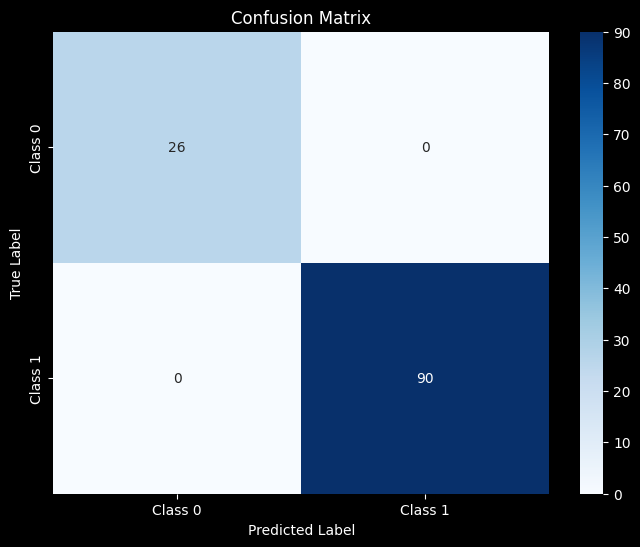

In [13]:
# applying the final model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import numpy as np

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # For ROC curve

# Calculating performance metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nTest set performance:")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# **Interpretation**
 eine Accuracy von 100% ist ein Hinweis darauf, dass möglicherweise Overfitting vorliegt. Dies sollte daher bedacht werden.
 Ist das nicht der Fall, kann es sich bei den Daten um sehr klare Unterscheidungen handeln.